yeni

<h1 style="color:red; animation: blink 1s infinite;">Balık Türlerini Sınıflandırma Projesi</h1>
<style>
@keyframes blink {
    0% { opacity: 1; }
    50% { opacity: 0; }
    100% { opacity: 1; }
}
</style># Balık Türlerini Sınıflandırma Projesi
Bu proje kapsamında, Kaggle'daki "A Large Scale Fish Dataset" veri seti kullanılarak balık türlerini sınıflandırmak için bir Derin Öğrenme modeli geliştireceğiz. Proje, veri ön işleme, model eğitimi ve model değerlendirmesi gibi adımları içermektedir.

Veri seti, balık resimlerinden oluşmaktadır ve bu resimler farklı klasörlerde, her klasör bir balık türünü temsil etmektedir.

In [1]:
# Gerekli kütüphanelerin yüklenmesi
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report


</style><h1 style="color:blue; animation: blink 1s infinite;">Kütüphaneler</h1>
<style>
@keyframes blink {
    0% { opacity: 1; }
    50% { opacity: 0; }
    100% { opacity: 1; }
}
</style>## **Kütüphaneler**
Projemizde `os`, `pandas`, `numpy`, `matplotlib` gibi temel kütüphaneler kullanılacaktır. Ayrıca, TensorFlow kullanarak yapay sinir ağımızı eğitmek için gerekli olan model ve katman yapılarını da yükleyeceğiz.


In [2]:
# Veri seti klasörünün yolu
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Etiket ve yol listelerini oluşturma
label = []
path = []

# Klasörlerdeki .png dosyalarını tarama
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        # .png uzantılı dosyaları kontrol et
        if os.path.splitext(filename)[-1] == '.png':
            # Klasör ismi "GT" değilse, bu klasör resim içeriyor demektir
            if 'GT' not in dir_name.split('/')[-1]:
                # Etiketi ekle
                label.append(os.path.split(dir_name)[-1])
                # Resmin yolunu ekle
                path.append(os.path.join(dir_name, filename))

# DataFrame oluşturma
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

# İlk 5 satırı görüntüleyelim
data.head()


,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


## Veri Setinin Yüklenmesi
Veri setimiz, balık resimlerinden oluşmaktadır. Her bir resim .png formatındadır ve resimler, balık türlerine göre klasörlere ayrılmıştır. Yukarıdaki kod ile, veri setimizdeki resim dosyalarının yollarını ve bunlara karşılık gelen balık türü etiketlerini bir pandas DataFrame'e yükledik.

Bu adımda:
- `os.walk()` fonksiyonu ile klasör yapısındaki resim dosyalarını taradık.
- `label` listesine her resmin balık türünü, `path` listesine ise resimlerin dosya yolunu ekledik.


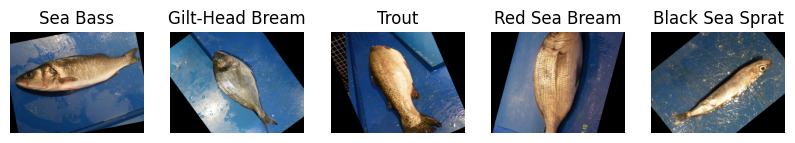

In [7]:
# Örnek görsellerin yüklenmesi ve gösterilmesi
sample_images = data.sample(5)

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sample_images['path']):
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(sample_images.iloc[i]['label'])
    plt.axis('off')
plt.show()


## Görsellerin Görselleştirilmesi
Yukarıda, rastgele seçilmiş 5 balık resmini ve bu resimlerin etiketlerini görselleştirdik. Bu, veri setimizi daha iyi anlamamıza yardımcı olur.


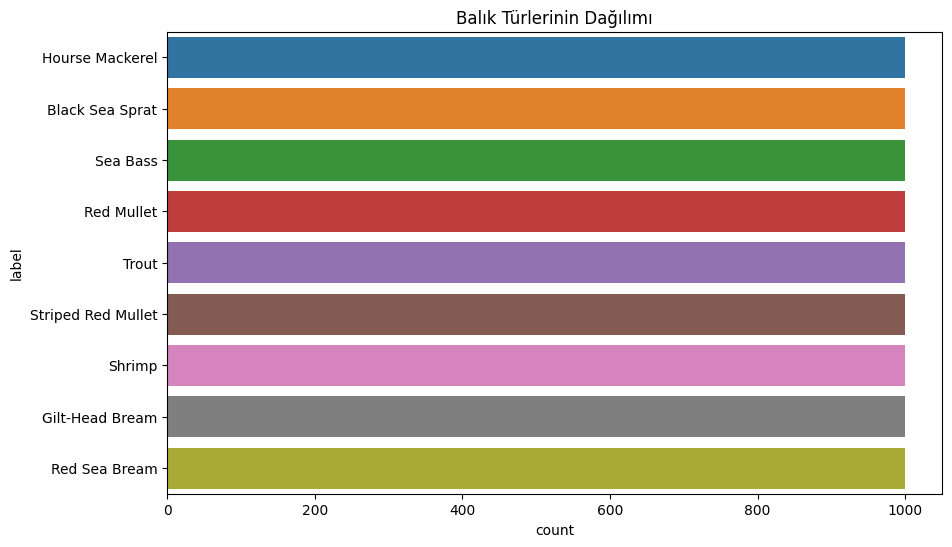

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(y='label', data=data, order=data['label'].value_counts().index)
plt.title("Balık Türlerinin Dağılımı")
plt.show()

Balık türlerinin Dağılımı görselleştirildi.

In [9]:
# Veri setini eğitim ve test olarak ayırma
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

# Eğitim ve test setlerinin boyutlarını kontrol etme
print(f"Eğitim veri seti boyutu: {train_data.shape[0]}")
print(f"Test veri seti boyutu: {test_data.shape[0]}")


Eğitim veri seti boyutu: 7200
Test veri seti boyutu: 1800


## Veri Setini Eğitim ve Test Olarak Ayırma
Veri setimizi %80 eğitim, %20 test olarak ayırdık. Bu aşamada, her balık türünden yeterli örnek olmasını sağlamak için `stratify` parametresi kullanılmıştır.


In [10]:
# Görüntüleri yeniden boyutlandırmak ve veri arttırmak için ImageDataGenerator kullanımı
image_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 7200 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


## Veri Arttırma
Veri setindeki görüntülerin sayısını arttırmak ve modelin daha iyi genelleme yapmasını sağlamak için veri arttırma (data augmentation) teknikleri kullandık. Görselleri döndürme, kaydırma, yakınlaştırma ve yatay çevirme gibi işlemlerle veri setini zenginleştiriyoruz.


In [11]:
# ANN modeli oluşturma
model = Sequential()

# Konvolüsyon katmanları
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully connected katmanlar
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model özetini görüntüleme
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,481 (28.20 MB)

 Trainable params: 7,393,481 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

## ANN Modeli Oluşturma
Bu adımda, yapay sinir ağı modelimizi oluşturuyoruz. Modelimizde:
- İki adet Konvolüsyon (Conv2D) katmanı, 
- MaxPooling ve Dropout katmanları,
- Fully connected katmanlar (Flatten ve Dense) yer almaktadır.
Son katmanımızda softmax aktivasyon fonksiyonu kullanarak sınıflandırmayı gerçekleştiriyoruz.


In [12]:
# Modeli eğitme
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=test_generator)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.1608 - loss: 2.3976 - val_accuracy: 0.3411 - val_loss: 1.7976
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 207s 902ms/step - accuracy: 0.2932 - loss: 1.7996 - val_accuracy: 0.5278 - val_loss: 1.2755
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 263s 908ms/step - accuracy: 0.4628 - loss: 1.3677 - val_accuracy: 0.6300 - val_loss: 1.0195
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 207s 905ms/step - accuracy: 0.5371 - loss: 1.1780 - val_accuracy: 0.6828 - val_loss: 0.8645
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 208s 908ms/step - accuracy: 0.6030 - loss: 1.0645 - val_accuracy: 0.7683 - val_loss: 0.6270
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 206s 901ms/step - accuracy: 0.6572 - loss: 0.9153 - val_accuracy: 0.8411 - val_loss: 0.4742
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 209s 912ms/step - accuracy: 0.7019 - loss: 0.7872 - val_accuracy: 0.8483 - val_loss: 0.4495
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 208s 905ms/step - accuracy: 0.7517 - loss: 0.6799 

## 9. Modelin Değerlendirilmesi

Eğitim sırasında elde edilen kayıp ve doğruluk değerlerini görselleştirerek modelimizin performansını değerlendirelim. Bu grafikler, modelimizin zaman içindeki öğrenme sürecini gösterir.


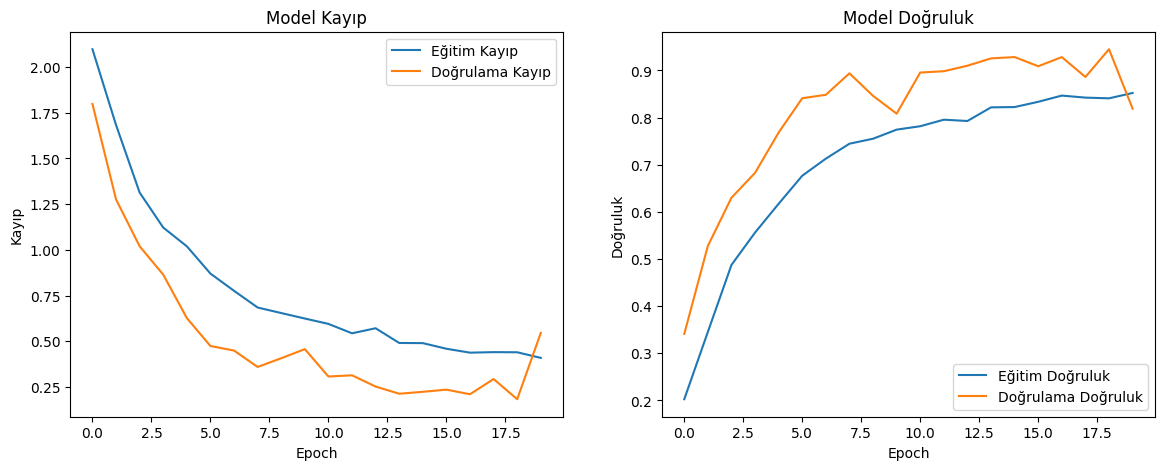

In [13]:
# Eğitim kayıpları ve doğrulukları görselleştirme
plt.figure(figsize=(14, 5))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kayıp')
plt.plot(history.history['val_loss'], label='Doğrulama Kayıp')
plt.title('Model Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluk')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluk')
plt.title('Model Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()


**Confussion Matrix kullanımı ile veriler arasındaki korelasyonların tespiti**

57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 448ms/step


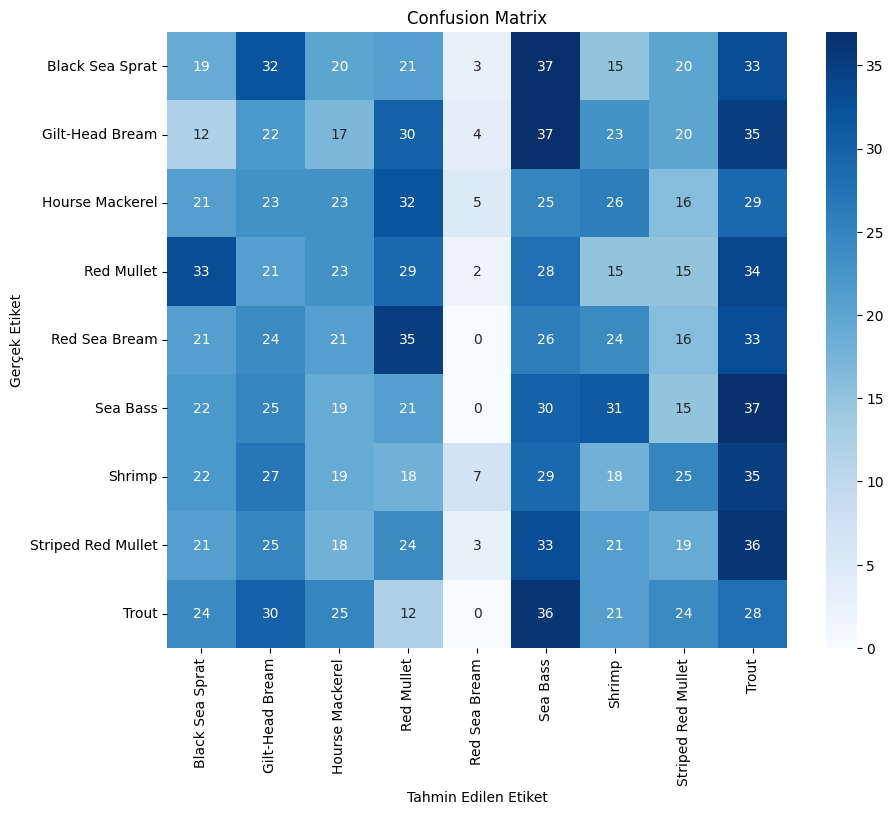

In [14]:
# Test verileri için tahmin yapma
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix oluşturma
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()


## 10. Sonuç ve Gelecek Çalışmalar

Bu projede, derin öğrenme yöntemleri kullanarak balık türlerini sınıflandırmayı başardık. Modelimizin doğruluk oranlarını artırmak için veri setimizi genişletebilir ve farklı model mimarileri deneyebiliriz. Gelecek çalışmalarımızda, modelimizi daha fazla balık türüyle zenginleştirmeyi hedefleyebiliriz.
